---
title: Allocative Bias Blog
author: Dean Smith
date: '2023-5-9'
image: "penguins.png"
description: "In this blog post, I use New Jersey employment data to build a machine learning model and examine the model for potential bias. "
format: html
---

# Auditing Allocative Bias

In this blog post I will perform a bias audit on an imported dataset of employment data for people in New Jersey. Throughout my audit, I will clean the data, group my data, find statistical values PPV, FNR, and FPR, lastly, I will do a calibration analysis and then conclude with a discussion.

First, I import my dataset and packages I need for my research.

In [1]:
from folktables import ACSDataSource, ACSIncome, BasicProblem, adult_filter
import numpy as np

STATE = "NJ"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000003,2,1,2302,1,34,1013097,12,23,...,23,3,12,2,3,14,12,13,12,2
1,P,2018GQ0000017,2,1,1800,1,34,1013097,11,51,...,19,2,9,9,19,10,19,19,2,10
2,P,2018GQ0000122,2,1,2104,1,34,1013097,24,69,...,45,22,45,2,3,24,24,23,44,1
3,P,2018GQ0000131,2,1,800,1,34,1013097,90,18,...,95,96,158,96,14,145,157,15,88,156
4,P,2018GQ0000134,2,1,1700,1,34,1013097,68,89,...,6,67,68,69,6,123,131,132,127,68


There is a lot of data here. I only want to use relevent features here so I will go ahead and clean my data.

In [2]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()



,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,23,21.0,5,17,2,NaN,5,2.0,4.0,1,2,2,2,2.0,1,6,6.0
1,51,20.0,4,17,2,NaN,4,1.0,4.0,1,2,2,2,2.0,1,1,1.0
2,69,19.0,3,16,1,NaN,1,1.0,4.0,4,1,2,2,2.0,1,1,6.0
3,18,16.0,5,16,1,NaN,1,1.0,4.0,2,1,2,2,1.0,2,9,6.0
4,89,19.0,2,16,1,NaN,1,1.0,4.0,4,1,2,2,1.0,2,1,6.0


I don't want to include Race or Employment status in my features so I will leave those out and get my features, labels, and group (Race).

In [3]:
features_to_use = [f for f in possible_features if f not in ['RAC1P', "ESR"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

Lets see the shape of our features and the size of our dataset.

In [4]:
for obj in [features, label, group]:
  print(obj.shape)

(88586, 15)
(88586,)
(88586,)


Now lets do a test/train split.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

Here, we put back our group (race) to groupby and our labels (employment status).

In [6]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

len(df)

70868

From the output of the code cell below, we can see that about 48% of individuals in our training data are employed.

In [7]:
df["label"].mean()

0.48490150702714907

Now, lets see how many people are in each racial group in our training data. Race group 1 is white, race group 2 is black, and the rest are other self-identified racial groups.

In [8]:
df.groupby("group").size()

group
1    51004
2     7419
3      114
4        2
5       62
6     7230
7       24
8     3233
9     1780
dtype: int64

Likewise, lets see what the employment rate for each racial group is.

In [9]:
df.groupby("group")["label"].mean()

group
1    0.495334
2    0.427281
3    0.464912
4    0.000000
5    0.467742
6    0.500000
7    0.541667
8    0.480359
9    0.374719
Name: label, dtype: float64

Now lets visualize this data in a bar graph where we also show the different sex groups within the racial groups. Sex group 1 is male and sex group 2 is female.

<Axes: xlabel='group', ylabel='mean'>

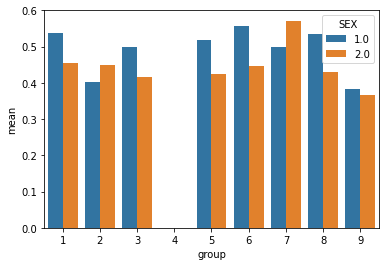

In [10]:
import seaborn as sns
counts = df.groupby(["group", "SEX"])["label"].mean().reset_index(name = "mean")
sns.barplot(data = counts, x = "group", y = "mean", hue = "SEX")

In the code cell below, we train our Logistic Regression model and see which number of polynomial features works best.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
import warnings

best_model = []
best_score = -1
best_dgegree = 0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for deg in range(0, 4):

        polynomial_logistic = Pipeline([
            ('poly', PolynomialFeatures(degree=deg)),
            ('logistic', LogisticRegression())
        ])

        iter_model = polynomial_logistic.fit(X_train, y_train)

        acc = iter_model.score(X_train, y_train)

        print("Degree of " + str(deg) + " -> Training Accuracy = " + str(acc))

        if acc > best_score:
            best_score = acc
            best_degree = deg
            best_model.append(iter_model)

print("Best Degree for Model: " + str(best_degree))

model = best_model[-1]


Degree of 0 -> Training Accuracy = 0.5150984929728509
Degree of 1 -> Training Accuracy = 0.7809730767059886
Degree of 2 -> Training Accuracy = 0.8139639893887227
Degree of 3 -> Training Accuracy = 0.812270700457188
Best Degree for Model: 2


Now lets get our model predictions for our testing data

In [12]:
y_hat = model.predict(X_test)

And now we see our model had a total accuracy of about 82%!

In [13]:
(y_hat == y_test).mean()

0.818828310193024

Below, we utilize a confusion matrix to get our model's PPV, FNR, and FPR.

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat, normalize='true').ravel()
ppv = tp / (tp + fp)
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

print("PPV: " + str(ppv))
print("FNR: " + str(fnr))
print("FPR: " + str(fpr))

PPV: 0.782381539141843
FNR: 0.11033274956217162
FPR: 0.24745984922976075


Now lets see what our model's accuracy, PPV, FNR, and FPR are for both our white racial group and our black racial group.

In [15]:
for group in range(1, 10):
    try:
        overall_acc = (y_hat == y_test)[group_test == group].mean()
        test = y_test[group_test == group]
        pred = y_hat[group_test == group]
        tn, fp, fn, tp = confusion_matrix(test, pred, normalize='true').ravel()
        ppv = tp / (tp + fp)
        fnr = fn / (fn + tp)
        fpr = fp / (fp + tn)

        print("Group " + str(group) + " overall accuracy: " + str(overall_acc)+ " | PPV: " + str(ppv) + " | FNR: " + str(fnr) + " | FPR: " + str(fpr) + "\n")
    except:
        print("Group " + str(group) + " does not have sufficient enough data.\n")




Group 1 overall accuracy: 0.8214816553234765 | PPV: 0.7868854900189419 | FNR: 0.11488750598372427 | FPR: 0.23971761817065684

Group 2 overall accuracy: 0.7940854326396495 | PPV: 0.7713154050034134 | FNR: 0.14140127388535031 | FPR: 0.25456292026897215

Group 3 overall accuracy: 0.7142857142857143 | PPV: 0.6341463414634146 | FNR: 0.06666666666666667 | FPR: 0.5384615384615384

Group 4 does not have sufficient enough data.

Group 5 overall accuracy: 0.75 | PPV: 0.7368421052631579 | FNR: 0.2 | FPR: 0.2857142857142857

Group 6 overall accuracy: 0.8223463687150838 | PPV: 0.750542721217512 | FNR: 0.04951560818083961 | FPR: 0.3159117305458769

Group 7 overall accuracy: 0.75 | PPV: 0.6666666666666666 | FNR: 0.0 | FPR: 0.5

Group 8 overall accuracy: 0.8109090909090909 | PPV: 0.7768496420047734 | FNR: 0.11764705882352941 | FPR: 0.2534562211981567

Group 9 overall accuracy: 0.8526785714285714 | PPV: 0.8417080876582216 | FNR: 0.11695906432748537 | FPR: 0.16606498194945848



As we can see, the model performs worse when dealing with black individuals as compared to white individuals. Additionally, the model performs better on white individuals than the total model average and worse on black individuals compared to the models average. However, the model had a higher PPV than the models average when predicting white individuals and a lower PPV when predicting black individuals. This means that when the model guesses that a white person is employed, the model correctly guesses it more than the average, but when the model guesses that a black person is employed, the model predicts worse than the average. In contrast, for black individuals, the model has a slightly higher FNR than the average meaning that when the model predicts a black person is unemployed then the model predicts wrong more than the average while the model's FNR for white indiviuals is about the average. Lastly, the FPR for black individuals is higher than the model's average and the FPR for white individuals is lower than the model's average. This means that when the model guesses someone is employed the person is really unemployed more often for black individuals than white individuals.

I can say with reasonable confidence that this model satisfies the error rate balance because despite true positives being slightly lower and false negatives being higher for black individuals, our model has higher false positives for black individuals. 

I believe this model also satisfies statistical parity because in our dataset white individuals have a higher employment rate than black individuals. This aligns with our findings because the FPR for black individuals is higher than white individuals and the PPV for white individuals is higher than black individuals be almost the same margin. 

Here, we put some data into our test dataframe for graphing later.

In [16]:
import pandas as pd
df_test = pd.DataFrame(X_test, columns = features_to_use)
df_test["group"] = group_test
df_test["label"] = y_test
df_test["prediction"] = y_hat

len(df)

70868

Now lets see if our model is calibrated.

<Axes: xlabel='prediction', ylabel='mean'>

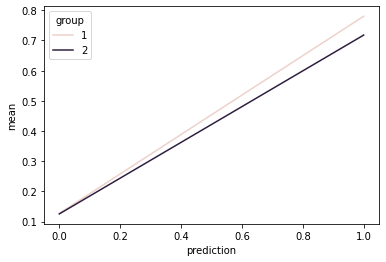

In [17]:
df_test = df_test[df_test["group"] < 3]

means = df_test.groupby(["group", "prediction"])["label"].mean().reset_index(name = "mean")
sns.lineplot(data = means, x = "prediction", y = "mean", hue = "group")

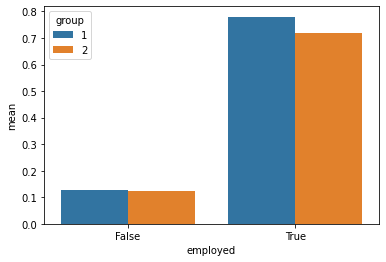

In [22]:
df_test["employed"] = df_test["prediction"] == 1

means = df_test.groupby(["group", "employed"])["label"].mean().reset_index(name = "mean")

p = sns.barplot(data = means, x = "employed", y = "mean", hue = "group")

Calibration:

From the two graphs above it I am not sure if my model is calibrated. The reason why I think it might not be is because in the bar graph above, for individuals that are employed the model predicts them to be employed significantly more for white people than for black people.

# Concluding Discussion

What groups of people could stand to benefit from a system that is able to predict the label you predicted, such as income or employment status? For example, what kinds of companies might want to buy your model for commercial use?

- Insurance companies or banks are the first ones that come to mind that could benefit from a model like this. Any company who benefits from knowing how much if any income is a person making would benefit from a model such as this one.

Based on your bias audit, what could be the impact of deploying your model for large-scale prediction in commercial or governmental settings?

- According to the data, black individuals are less likely to be employed than white individuals. The model has picked up on this trend however I believe that incorporating this trend into a model used in a large-scale prediction would be detrimental to black individuals as a whole. The model would perpetuate negative biases about black peoples employment which would be a large issue. 

Based on your bias audit, do you feel that your model displays problematic bias? What kind (calibration, error rate, etc)?

- I believe my model's error rate reflects the population in the testing data. However I feel that in this data there are biases that the model has picked up on. I also feel that there can be a calibration issue with my model.

Beyond bias, are there other potential problems associated with deploying your model that make you uncomfortable? How would you propose addressing some of these problems?

- I feel uncomfortable with the fact that I have only done a limited number of tests for potential biases in my model. There could definitely be more and I would not feel comfortable releasing this model to the world with further testing for biases.